In [1]:
from collections import defaultdict

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import tqdm
from torch.utils.data import DataLoader, Dataset

In [2]:
DATASET_PATH = "combined-dataset.h5"
BUDGET = 8
BATCH_SIZE = 256
NUM_WORKERS = 4

In [3]:
with h5py.File(DATASET_PATH, "r") as f:
    primitives = list(f.attrs["primitives"])
    depth_min = f.attrs["depth_min"]
    depth_max = f.attrs["depth_max"]
    dist_max = f.attrs["dist_max"]
    keys = list(f.keys())

print(f"Primitives: {primitives}")
print(f"Total samples: {len(keys)}")

Primitives: ['push_x_pos', 'push_x_neg', 'push_y_pos', 'push_y_neg', 'lift_x', 'lift_y', 'pull_x', 'pull_y']
Total samples: 49694


In [4]:
class EvalDataset(Dataset):
    def __init__(self, hdf5_path, indices, keys):
        self.hdf5_path = hdf5_path
        self.indices = indices
        self.keys = keys

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        with h5py.File(self.hdf5_path, "r") as f:
            dp = f[self.keys[self.indices[idx]]]
            return {
                "depth": torch.from_numpy(dp["depth"][()]),
                "mask": torch.from_numpy(dp["mask"][()]),
                "dist_map": torch.from_numpy(dp["dist_map"][()]),
                "target_offset": torch.from_numpy(dp["target_offset"][()]),
                "quat": torch.from_numpy(dp["quat"][()]),
                "feasibles": torch.from_numpy(dp["feasibles"][()]),
            }

In [5]:
scene_to_indices = defaultdict(list)
for idx, key in enumerate(keys):
    scene_to_indices[key.rsplit("_obj_", 1)[0]].append(idx)

scene_ids = list(scene_to_indices.keys())
num_train = int(len(scene_ids) * 0.8)
num_val = int(len(scene_ids) * 0.1)
test_scenes = scene_ids[num_train + num_val :]
test_indices = [idx for scene in test_scenes for idx in scene_to_indices[scene]]

print(f"Test: {len(test_scenes)} scenes, {len(test_indices)} samples")

Test: 1101 scenes, 4995 samples


In [6]:
dataset = EvalDataset(DATASET_PATH, test_indices, keys)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [7]:
class PatchEmbed(nn.Module):
    def __init__(self, img_size=(256, 384), patch_size=16, in_channels=2, embed_dim=192):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size, img_size[1] // patch_size)
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

        nn.init.trunc_normal_(self.proj.weight, std=0.02)
        nn.init.zeros_(self.proj.bias)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x


class ViT(nn.Module):
    def __init__(self, img_size=(256, 384), patch_size=16, in_channels=2, embed_dim=192, depth=4, num_heads=6, mlp_ratio=2.0, dropout=0.1):
        super().__init__()

        self.patch_embed = PatchEmbed(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        nn.init.trunc_normal_(self.cls_token, std=0.02)

        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=int(embed_dim * mlp_ratio),
            dropout=dropout,
            activation="gelu",
            batch_first=True,
            norm_first=False,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        self._init_transformer_weights()

        self.norm = nn.LayerNorm(embed_dim)

    def _init_transformer_weights(self):
        for module in self.transformer.modules():
            if isinstance(module, nn.Linear):
                nn.init.trunc_normal_(module.weight, std=0.02)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
            elif isinstance(module, nn.LayerNorm):
                nn.init.ones_(module.weight)
                nn.init.zeros_(module.bias)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + self.pos_embed
        x = self.transformer(x)
        x = self.norm(x)
        x = x[:, 0]
        return x


class DistanceViT(nn.Module):
    def __init__(self, img_size=(256, 384), patch_size=16, embed_dim=256, depth=6, num_heads=8):
        super().__init__()

        self.vision_encoder = ViT(
            img_size=img_size, patch_size=patch_size, in_channels=3, embed_dim=embed_dim, depth=depth, num_heads=num_heads, dropout=0.2
        )

        self.quat_encoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.GELU(),
            nn.Dropout(0.2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(embed_dim + 64, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 8),
        )

    def forward(self, depth, mask, goal, quat):
        vision_feat = self.vision_encoder(torch.stack([depth, mask, goal], dim=1))
        quat_feat = self.quat_encoder(quat)
        return self.classifier(torch.cat([vision_feat, quat_feat], dim=1))


class OffsetVit(nn.Module):
    def __init__(self, img_size=(256, 384), patch_size=16, embed_dim=192, depth=4, num_heads=6):
        super().__init__()

        self.vision_encoder = ViT(
            img_size=img_size,
            patch_size=patch_size,
            in_channels=2,
            embed_dim=embed_dim,
            depth=depth,
            num_heads=num_heads,
            dropout=0.2,
        )

        self.quat_encoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.GELU(),
            nn.Dropout(0.2),
        )

        self.target_encoder = nn.Sequential(
            nn.Linear(3, 64),
            nn.GELU(),
            nn.Dropout(0.2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(embed_dim + 64 + 64, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 8),
        )

    def forward(self, depth, mask, target_offset, quat):
        vision_feat = self.vision_encoder(torch.stack([depth, mask], dim=1))
        target_feat = self.target_encoder(target_offset)
        quat_feat = self.quat_encoder(quat)
        return self.classifier(torch.cat([vision_feat, target_feat, quat_feat], dim=1))


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.conv(x))


class DistanceCNN(nn.Module):
    def __init__(self, num_primitives):
        super().__init__()

        self.conv1 = ConvBlock(3, 16, kernel_size=7, stride=2, padding=3)  # 128x192
        self.conv2 = ConvBlock(16, 32, kernel_size=3, stride=2, padding=1)  # 64x96
        self.conv3 = ConvBlock(32, 64, kernel_size=3, stride=2, padding=1)  # 32x48

        self.pool = nn.AdaptiveAvgPool2d((8, 12))  # 8x12
        self.dropout = nn.Dropout(0.2)

        vision_feat_dim = 64 * 8 * 12

        self.quat_encoder = nn.Sequential(
            nn.Linear(4, 64),
            nn.GELU(),
            nn.Dropout(0.2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(vision_feat_dim + 64, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_primitives),
        )

    def forward(self, depth, mask, goal, quat):
        x = torch.stack([depth, mask, goal], dim=1)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = self.pool(x)
        x = self.dropout(x)
        vision_feat = x.flatten(1)

        quat_feat = self.quat_encoder(quat)

        return self.classifier(torch.cat([vision_feat, quat_feat], dim=1))

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

distance_model = DistanceViT()
distance_model.load_state_dict(torch.load("distance-model-83.pt", map_location=device)["model_state_dict"])
distance_model = distance_model.to(device).eval()

offset_model = OffsetVit()
offset_model.load_state_dict(torch.load("offset-model-95.pt", map_location=device)["model_state_dict"])
offset_model = offset_model.to(device).eval()

cnn_model = DistanceCNN(8)
cnn_model.load_state_dict(torch.load("cnn-model-100.pt", map_location=device)["model_state_dict"])
cnn_model = cnn_model.to(device).eval()

print(f"Distance ViT: {sum(p.numel() for p in distance_model.parameters()):,} params")
print(f"Offset ViT: {sum(p.numel() for p in offset_model.parameters()):,} params")
print(f"CNN: {sum(p.numel() for p in cnn_model.parameters()):,} params")

Distance ViT: 3,756,872 params
Offset ViT: 1,659,400 params
CNN: 3,338,216 params


In [41]:
HARDCODED_RANKING = ["lift_x", "lift_y", "pull_x", "pull_y", "push_x_pos", "push_x_neg", "push_y_pos", "push_y_neg"]

In [42]:
sample_metadata = []

print("Evaluating on test set...")
sample_idx = 0
with torch.no_grad():
    for batch in tqdm.tqdm(loader):
        depth = batch["depth"].to(device)
        mask = batch["mask"].to(device)
        dist_map = batch["dist_map"].to(device)
        target_offset = batch["target_offset"].to(device)
        quat = batch["quat"].to(device)
        feasibles = batch["feasibles"].cpu().numpy()

        batch_size = depth.shape[0]

        # Get predictions (logits)
        distance_logits = distance_model(depth, mask, dist_map, quat).sigmoid().cpu().numpy()
        offset_logits = offset_model(depth, mask, target_offset, quat).sigmoid().cpu().numpy()
        cnn_logits = cnn_model(depth, mask, dist_map, quat).sigmoid().cpu().numpy()

        distance_rankings = distance_logits.argsort(axis=1)[:, ::-1]
        offset_rankings = offset_logits.argsort(axis=1)[:, ::-1]
        cnn_rankings = cnn_logits.argsort(axis=1)[:, ::-1]

        for i in range(batch_size):
            global_idx = test_indices[sample_idx]
            key = keys[global_idx]

            # Compute calls for each method
            distance_calls = BUDGET + 1
            offset_calls = BUDGET + 1
            cnn_calls = BUDGET + 1

            for k, prim_idx in enumerate(distance_rankings[i, :BUDGET], start=1):
                if feasibles[i, prim_idx]:
                    distance_calls = k
                    break

            for k, prim_idx in enumerate(offset_rankings[i, :BUDGET], start=1):
                if feasibles[i, prim_idx]:
                    offset_calls = k
                    break

            for k, prim_idx in enumerate(cnn_rankings[i, :BUDGET], start=1):
                if feasibles[i, prim_idx]:
                    cnn_calls = k
                    break

            # Random
            random_ranking = list(range(len(primitives)))
            np.random.shuffle(random_ranking)
            random_calls = BUDGET + 1
            for k, prim_idx in enumerate(random_ranking[:BUDGET], start=1):
                if feasibles[i, prim_idx]:
                    random_calls = k
                    break

            # Hardcoded
            hardcoded_ranking = [primitives.index(p) for p in HARDCODED_RANKING]
            hardcoded_calls = BUDGET + 1
            for k, prim_idx in enumerate(hardcoded_ranking[:BUDGET], start=1):
                if feasibles[i, prim_idx]:
                    hardcoded_calls = k
                    break

            # Store metadata for this sample
            num_feasible = feasibles[i].sum()
            sample_metadata.append(
                {
                    "idx": sample_idx,
                    "global_idx": global_idx,
                    "key": key,
                    "feasibles": feasibles[i].copy(),
                    "num_feasible": num_feasible,
                    "distance_calls": distance_calls,
                    "offset_calls": offset_calls,
                    "cnn_calls": cnn_calls,
                    "random_calls": random_calls,
                    "hardcoded_calls": hardcoded_calls,
                    "distance_ranking": distance_rankings[i].copy(),
                    "distance_predictions": distance_logits[i].copy(),
                    "offset_ranking": offset_rankings[i].copy(),
                    "offset_predictions": offset_logits[i].copy(),
                    "cnn_ranking": cnn_rankings[i].copy(),
                    "cnn_predictions": cnn_logits[i].copy(),
                }
            )

            sample_idx += 1

print(f"Evaluated {len(sample_metadata)} samples")

df = pd.DataFrame(sample_metadata)

Evaluating on test set...


100%|██████████| 20/20 [00:08<00:00,  2.41it/s]

Evaluated 4995 samples


In [59]:
# Constants
BUDGET = 8 # Assuming 8 primitives

# 1. Filter dataset to only include tasks that are actually solvable
# We only calculate efficiency metrics on tasks where a solution EXISTS.
# solvable_df = df[df["num_feasible"] > 0].copy()
solvable_df = df.copy()
total_solvable = len(solvable_df)

print(f"Total tasks evaluated: {len(df)}")
print(f"Solvable tasks: {total_solvable} ({total_solvable/len(df):.1%})")
print("-" * 80)

methods = [
    ("Random", "random_calls"),
    ("Type-Based", "hardcoded_calls"),
    ("CNN", "cnn_calls"),
    ("Offset Model", "offset_calls"),
    ("Distance Model", "distance_calls"),
]

results = []

for name, col in methods:
    # Filter rows where this method actually solved it within budget
    # (Your code sets failed attempts to BUDGET + 1)
    solved_mask = solvable_df[col] <= BUDGET
    solved_data = solvable_df[solved_mask]
    
    num_solved = len(solved_data)
    
    # Calculate Metrics
    success_rate = num_solved / total_solvable * 100
    avg_calls = solved_data[col].mean()
    
    # Calculate Success on First Try (k=1)
    first_try_success = (solvable_df[col] == 1).sum() / total_solvable * 100

    results.append({
        "Method": name,
        "Avg Calls": avg_calls,
        "Success Rate (%)": success_rate,
        "First Try Success (%)": first_try_success
    })

# Create DataFrame
metrics_df = pd.DataFrame(results)

# Calculate Speedup relative to Random
random_baseline = metrics_df.loc[metrics_df["Method"] == "Random", "Avg Calls"].values[0]
metrics_df["Speedup"] = random_baseline / metrics_df["Avg Calls"]

# Calculate Reduction % ((Random - Method) / Random)
metrics_df["Reduction (%)"] = (random_baseline - metrics_df["Avg Calls"]) / random_baseline * 100

# Formatting for display
print(metrics_df.to_string(index=False, float_format="%.3f"))

print("-" * 80)
print("LATEX TABLE VALUES:")
print("-" * 80)
for _, row in metrics_df.iterrows():
    print(f"{row['Method']} & {row['Avg Calls']:.2f} & {row['Reduction (%)']:.1f}\\% & {row['Speedup']:.2f}x \\\\")

Total tasks evaluated: 4995
Solvable tasks: 4995 (100.0%)
--------------------------------------------------------------------------------
        Method  Avg Calls  Success Rate (%)  First Try Success (%)  Speedup  Reduction (%)
        Random      2.787            90.330                 30.070    1.000          0.000
    Type-Based      2.438            90.330                 45.165    1.143         12.510
           CNN      1.211            90.330                 76.657    2.301         56.545
  Offset Model      1.176            90.330                 77.818    2.370         57.802
Distance Model      1.084            90.330                 84.985    2.571         61.102
--------------------------------------------------------------------------------
LATEX TABLE VALUES:
--------------------------------------------------------------------------------
Random & 2.79 & 0.0\% & 1.00x \\
Type-Based & 2.44 & 12.5\% & 1.14x \\
CNN & 1.21 & 56.5\% & 2.30x \\
Offset Model & 1.18 & 57.8\% & 

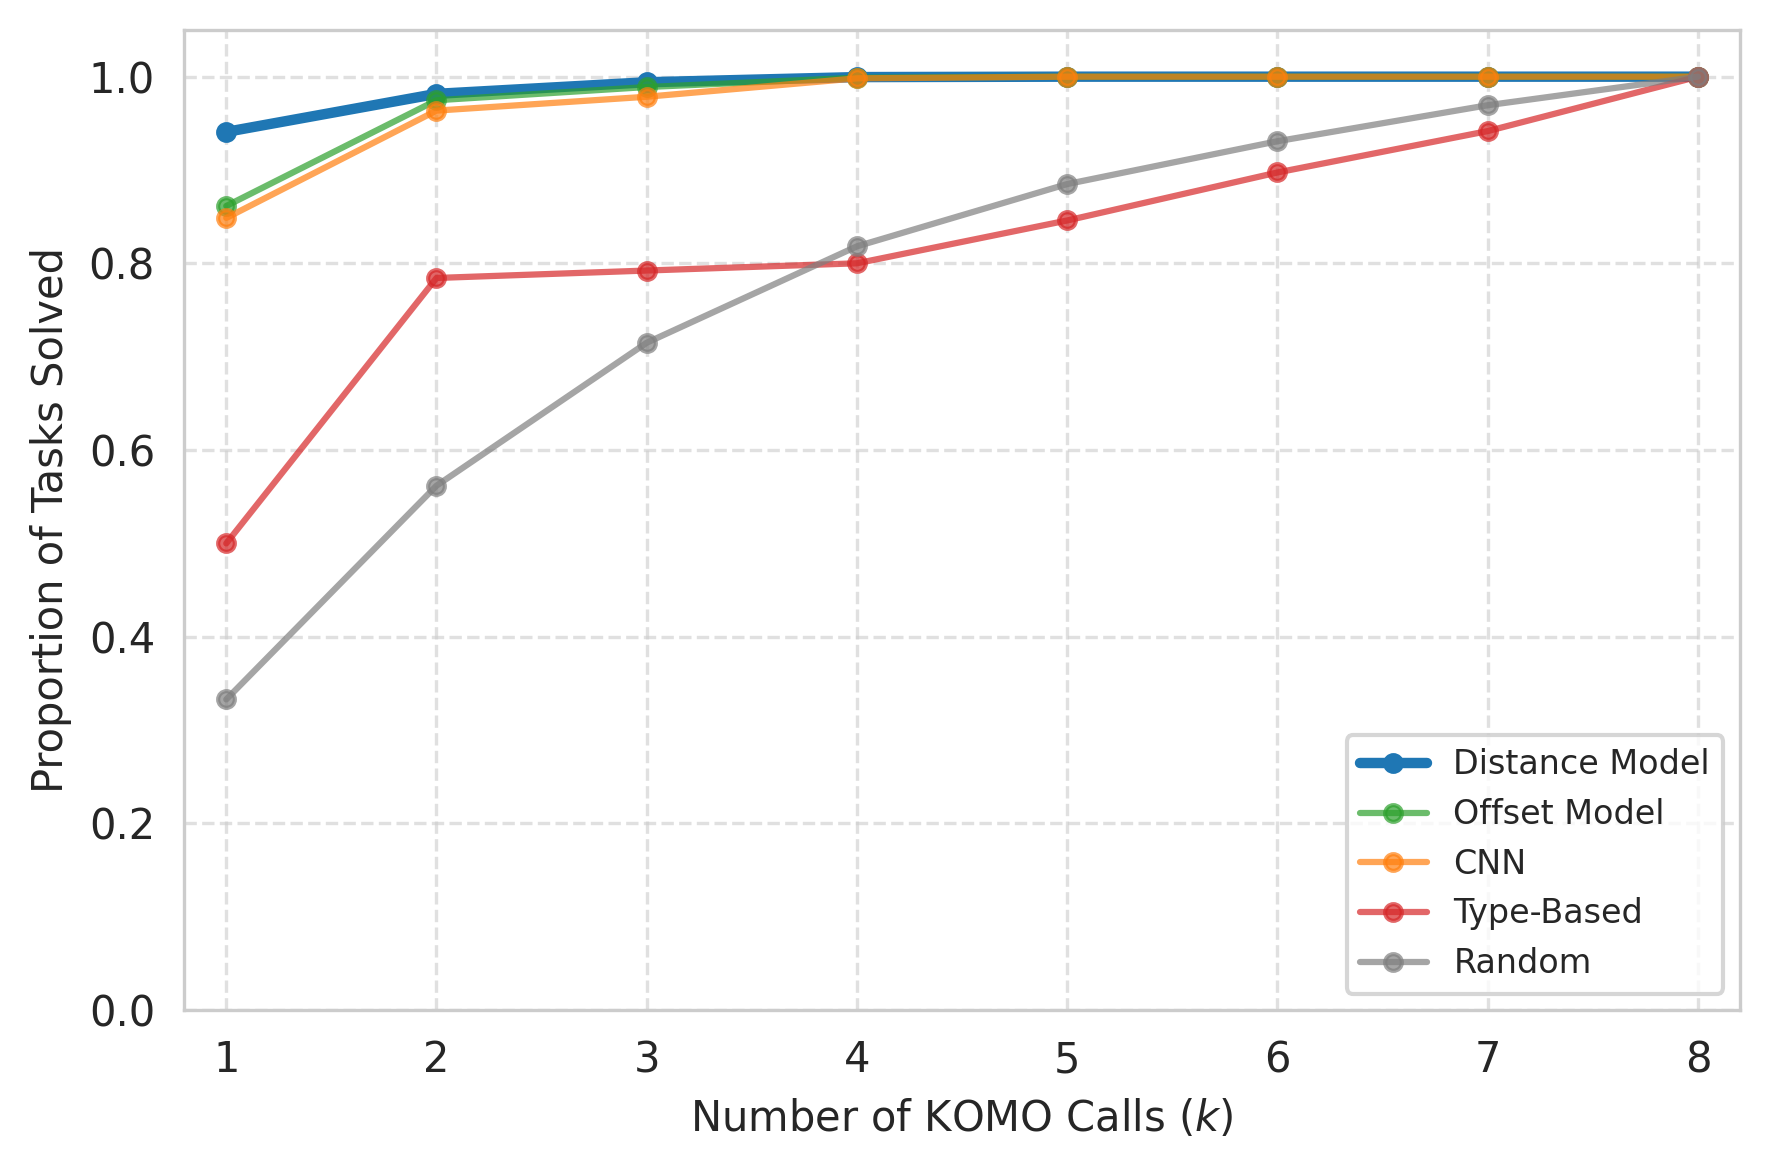

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Setup
sns.set_style("whitegrid")
plt.figure(figsize=(6, 4), dpi=300)

# Filter for solvable only (as you decided)
plot_df = df[df["num_feasible"] > 0].copy()
total_solvable = len(plot_df)

# The columns you have in your dictionary
methods = {
    "Distance Model": "distance_calls",
    "Offset Model": "offset_calls", 
    "CNN": "cnn_calls",
    "Type-Based": "hardcoded_calls",
    "Random": "random_calls"
}

colors = {
    "Distance Model": "#1f77b4",  # Blue (Highlight)
    "Offset Model": "#2ca02c",    # Green
    "CNN": "#ff7f0e",             # Orange
    "Type-Based": "#d62728",      # Red
    "Random": "#7f7f7f"           # Gray
}

# Generate curves
budget_range = range(1, 9)

for name, col in methods.items():
    success_rates = []
    for k in budget_range:
        # Count how many tasks were solved with <= k calls
        num_solved = (plot_df[col] <= k).sum()
        rate = num_solved / total_solvable
        success_rates.append(rate)
    
    # Plotting
    lw = 2.5 if name == "Distance Model" else 1.5
    alpha = 1.0 if name == "Distance Model" else 0.7
    
    plt.plot(budget_range, success_rates, 
             label=name, 
             color=colors[name], 
             linewidth=lw, 
             alpha=alpha,
             marker='o', 
             markersize=4)

# Styling
plt.xlabel("Number of KOMO Calls ($k$)", fontsize=10)
plt.ylabel("Proportion of Tasks Solved", fontsize=10)
plt.ylim(0, 1.05)
plt.xlim(0.8, 8.2)
plt.legend(fontsize=8, loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save
plt.savefig("cumulative-success.pdf")
plt.show()

In [45]:
import pandas as pd
import numpy as np

# Constants
BUDGET = 8  # Assuming 8 primitives

# 1. Filter dataset to only include tasks that are actually solvable
# We only calculate efficiency metrics on tasks where a solution EXISTS.
solvable_df = df[df["num_feasible"] > 0].copy()
total_solvable = len(solvable_df)

print(f"Total tasks evaluated: {len(df)}")
print(f"Solvable tasks: {total_solvable} ({total_solvable / len(df):.1%})")
print("-" * 80)

methods = [
    ("Random", "random_calls"),
    ("Type-Based", "hardcoded_calls"),
    ("CNN", "cnn_calls"),
    ("Offset Model", "offset_calls"),
    ("Distance Model", "distance_calls"),
]

results = []

for name, col in methods:
    # Filter rows where this method actually solved it within budget
    # (Your code sets failed attempts to BUDGET + 1)
    solved_mask = solvable_df[col] <= BUDGET
    solved_data = solvable_df[solved_mask]

    num_solved = len(solved_data)

    # Calculate Metrics
    success_rate = num_solved / total_solvable * 100
    avg_calls = solved_data[col].mean()

    # Calculate Success on First Try (k=1)
    first_try_success = (solvable_df[col] == 1).sum() / total_solvable * 100

    results.append({"Method": name, "Avg Calls": avg_calls, "Success Rate (%)": success_rate, "First Try Success (%)": first_try_success})

# Create DataFrame
metrics_df = pd.DataFrame(results)

# Calculate Speedup relative to Random
random_baseline = metrics_df.loc[metrics_df["Method"] == "Random", "Avg Calls"].values[0]
metrics_df["Speedup"] = random_baseline / metrics_df["Avg Calls"]

# Calculate Reduction % ((Random - Method) / Random)
metrics_df["Reduction (%)"] = (random_baseline - metrics_df["Avg Calls"]) / random_baseline * 100

# Formatting for display
print(metrics_df.to_string(index=False, float_format="%.3f"))

print("-" * 80)
print("LATEX TABLE VALUES:")
print("-" * 80)
for _, row in metrics_df.iterrows():
    print(f"{row['Method']} & {row['Avg Calls']:.2f} & {row['Reduction (%)']:.1f}\\% & {row['Speedup']:.2f}x \\\\")


Total tasks evaluated: 4995
Solvable tasks: 4512 (90.3%)
--------------------------------------------------------------------------------
        Method  Avg Calls  Success Rate (%)  First Try Success (%)  Speedup  Reduction (%)
        Random      2.787           100.000                 33.289    1.000          0.000
    Type-Based      2.438           100.000                 50.000    1.143         12.510
           CNN      1.211           100.000                 84.863    2.301         56.545
  Offset Model      1.176           100.000                 86.148    2.370         57.802
Distance Model      1.084           100.000                 94.082    2.571         61.102
--------------------------------------------------------------------------------
LATEX TABLE VALUES:
--------------------------------------------------------------------------------
Random & 2.79 & 0.0\% & 1.00x \\
Type-Based & 2.44 & 12.5\% & 1.14x \\
CNN & 1.21 & 56.5\% & 2.30x \\
Offset Model & 1.18 & 57.8\% & 2

In [46]:
import torch.nn.functional as F


def get_last_layer_attention(model, depth, mask, dist_map):
    """
    Manually runs the ViT forward pass to extract attention weights from the last layer.
    """
    # 1. Prepare Input
    x = torch.stack([depth, mask, dist_map], dim=1)

    # 2. Patch Embedding & Positional Encoding (Replicating ViT.forward)
    B = x.shape[0]
    x = model.vision_encoder.patch_embed(x)
    cls_tokens = model.vision_encoder.cls_token.expand(B, -1, -1)
    x = torch.cat([cls_tokens, x], dim=1)
    x = x + model.vision_encoder.pos_embed

    # 3. Run through Transformer Layers 0 to L-1
    # We access the internal module list of the encoder
    layers = model.vision_encoder.transformer.layers
    for i in range(len(layers) - 1):
        x = layers[i](x)

    # 4. Manual Attention Calculation for the Last Layer
    last_layer = layers[-1]

    # In Post-Norm (norm_first=False), the input to self_attn is just x
    # We need to access the Linear weights for Q, K, V from the MultiheadAttention module
    # PyTorch stores these in a single fused matrix: in_proj_weight
    attn_module = last_layer.self_attn
    embed_dim = model.vision_encoder.cls_token.shape[-1]
    num_heads = attn_module.num_heads
    head_dim = embed_dim // num_heads

    # Project x to Q, K, V
    # x shape: [B, SeqLen, Dim]
    # weight shape: [3*Dim, Dim]
    qkv = F.linear(x, attn_module.in_proj_weight, attn_module.in_proj_bias)
    qkv = qkv.reshape(B, x.shape[1], 3, num_heads, head_dim)
    qkv = qkv.permute(2, 0, 3, 1, 4)  # [3, B, Heads, SeqLen, HeadDim]
    q, k, v = qkv[0], qkv[1], qkv[2]

    # Compute Scaled Dot-Product Attention
    # attn_weights: [B, Heads, SeqLen, SeqLen]
    attn_weights = (q @ k.transpose(-2, -1)) * (head_dim**-0.5)
    attn_weights = F.softmax(attn_weights, dim=-1)

    # 5. Extract Attention from CLS token to all other tokens
    # Index 0 is CLS. We want row 0, columns 1:end (skipping self-attention to CLS)
    # Shape: [B, Heads, NumPatches]
    cls_attn = attn_weights[:, :, 0, 1:]

    return cls_attn

Found 36 interesting samples. Showing the first one...


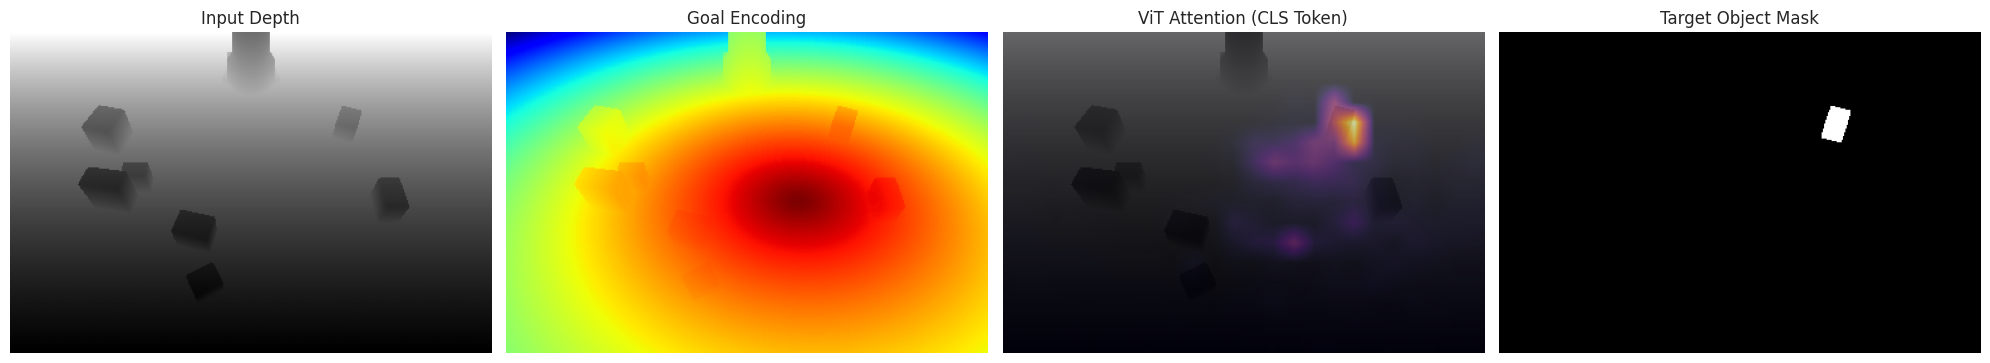

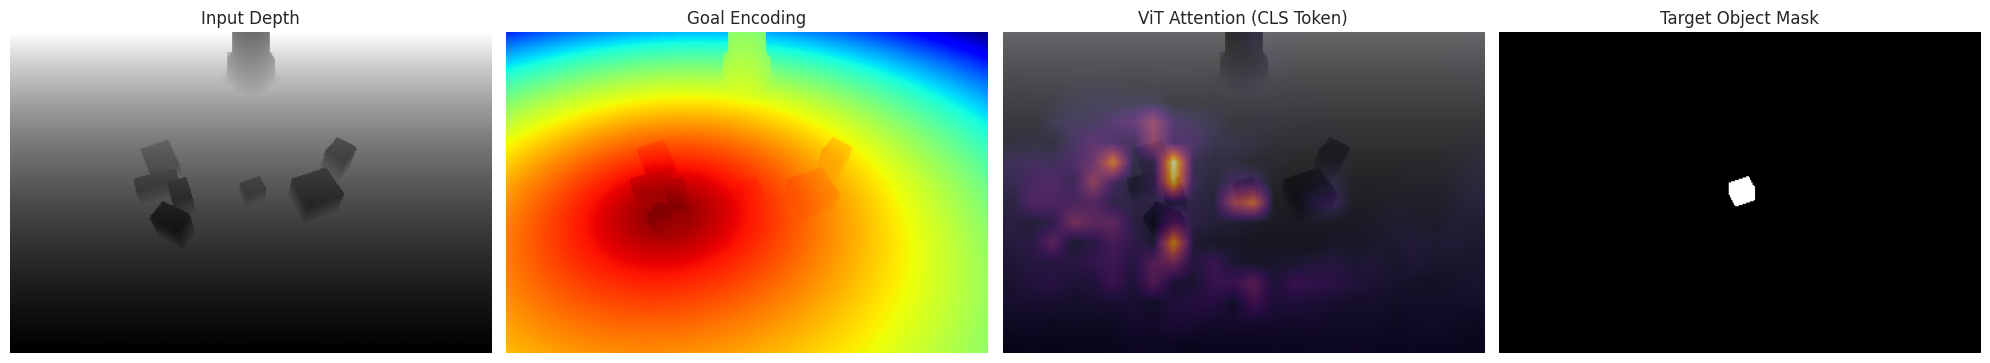

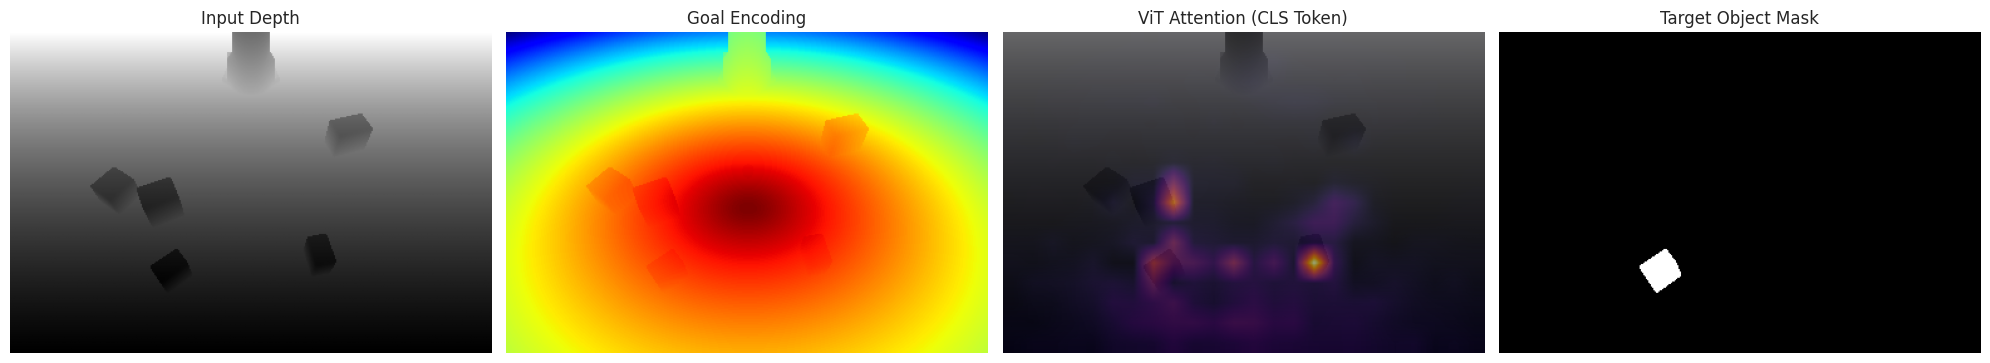

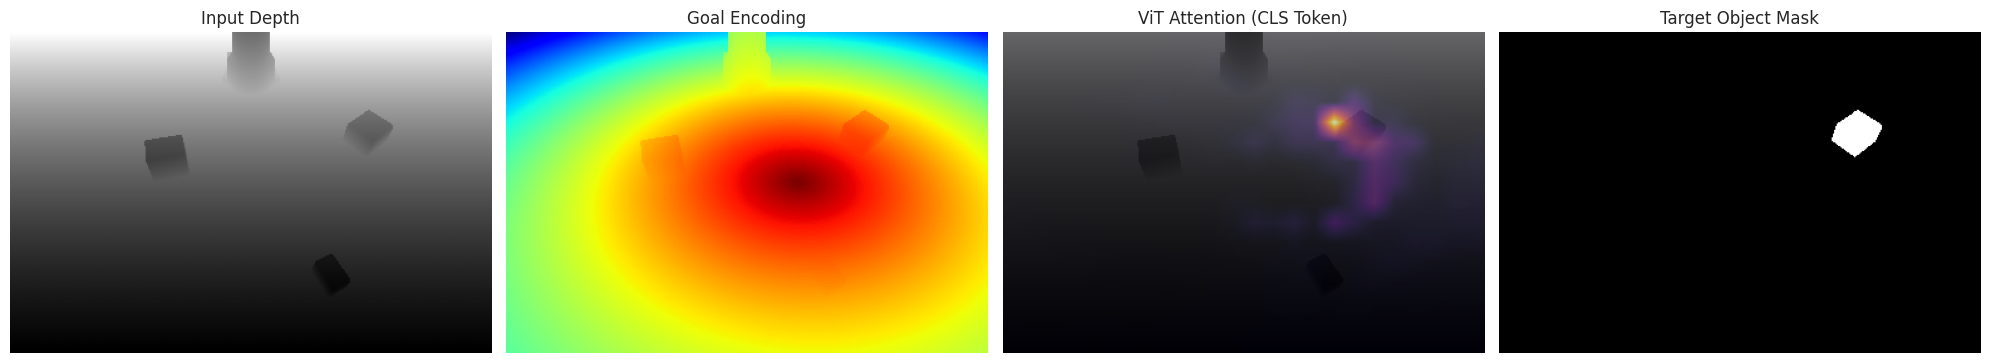

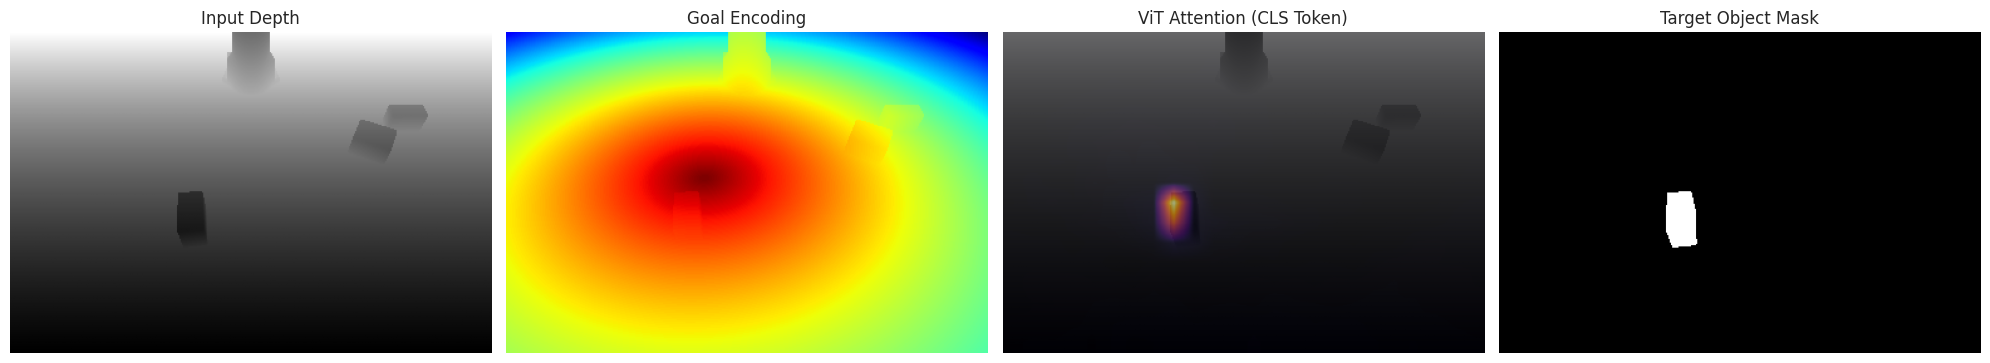

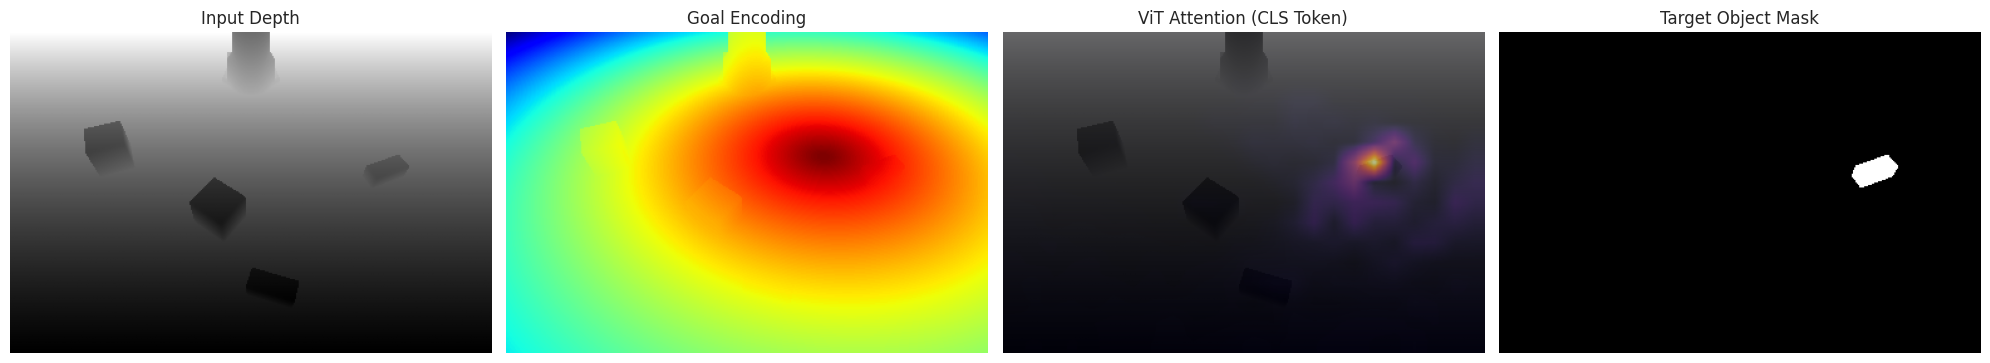

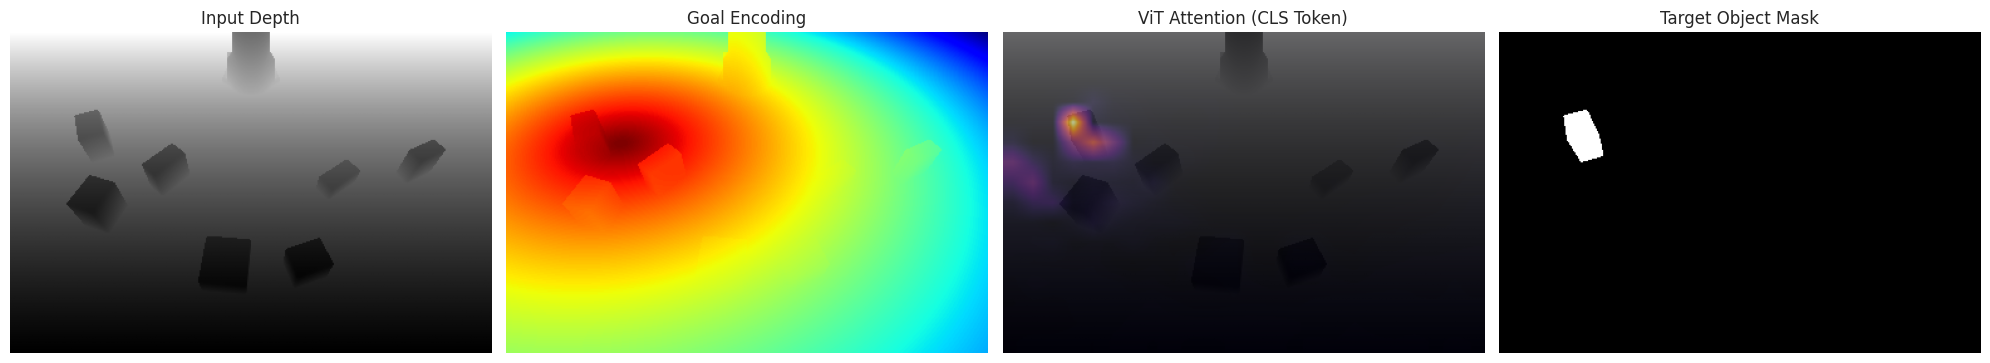

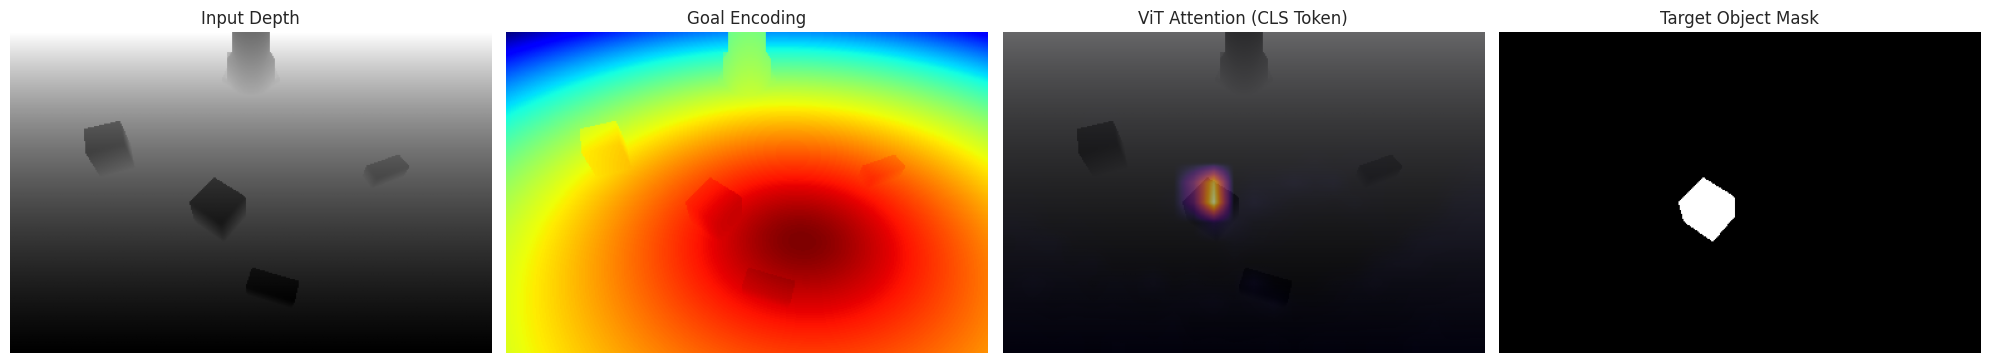

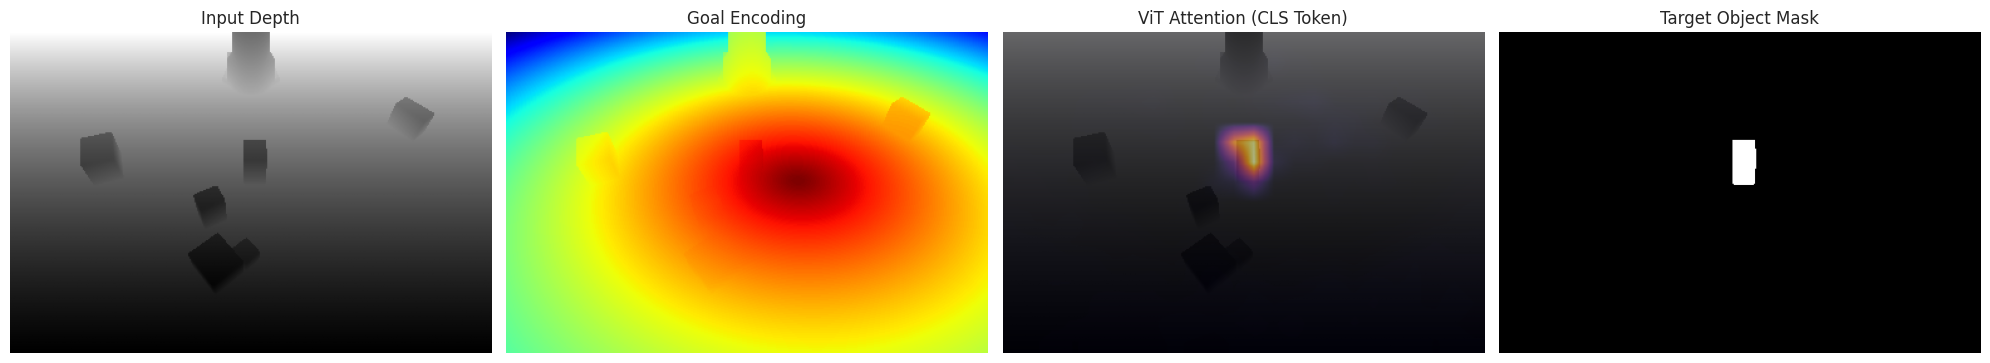

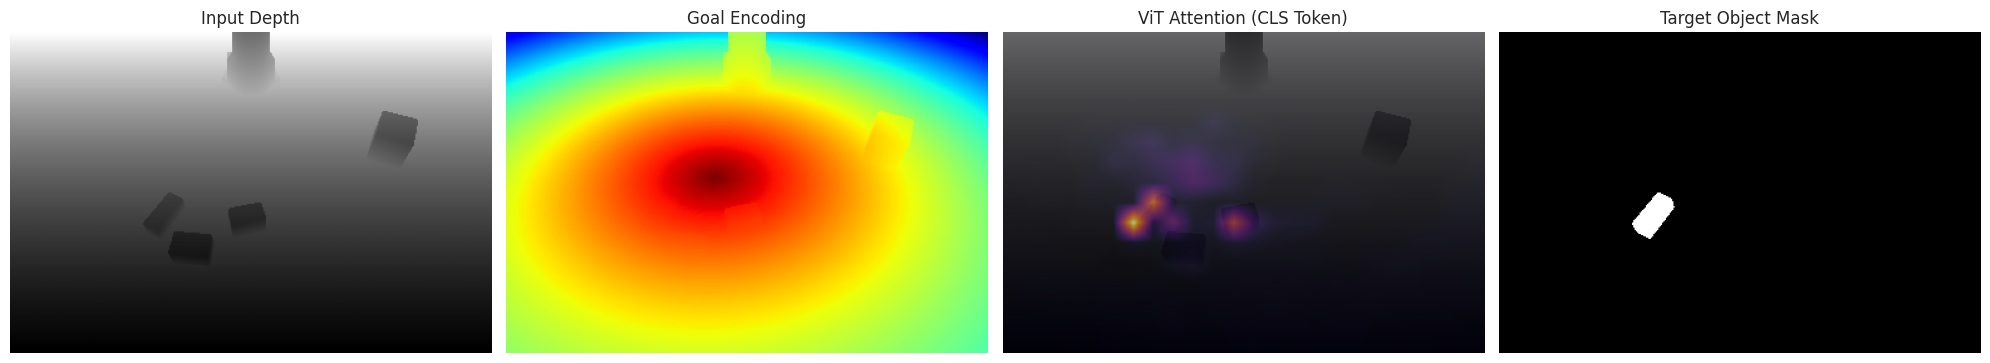

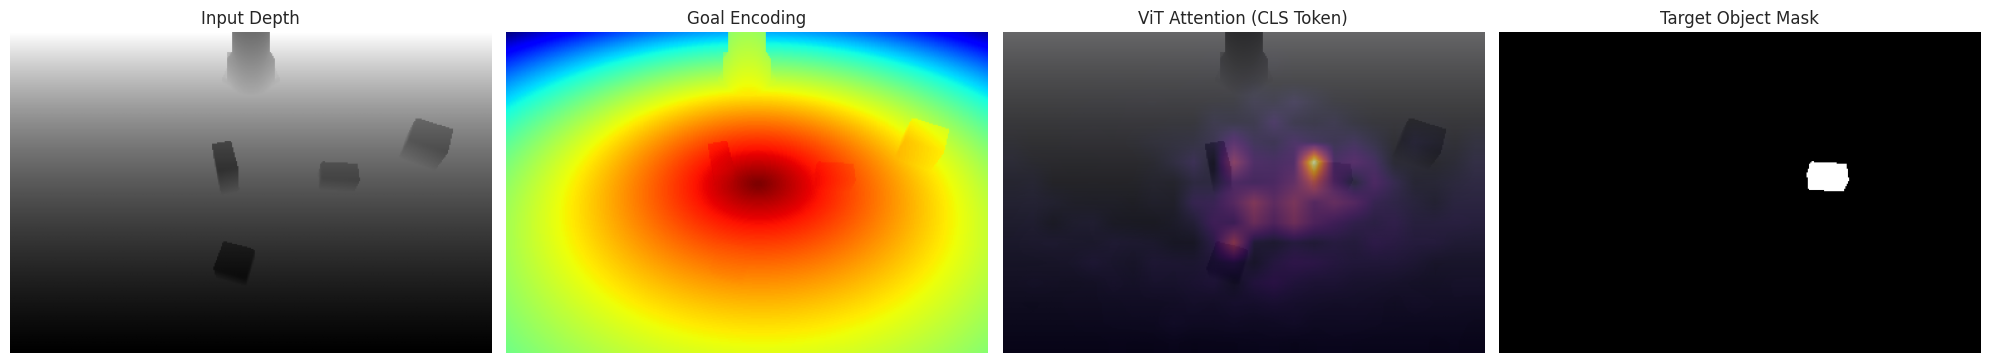

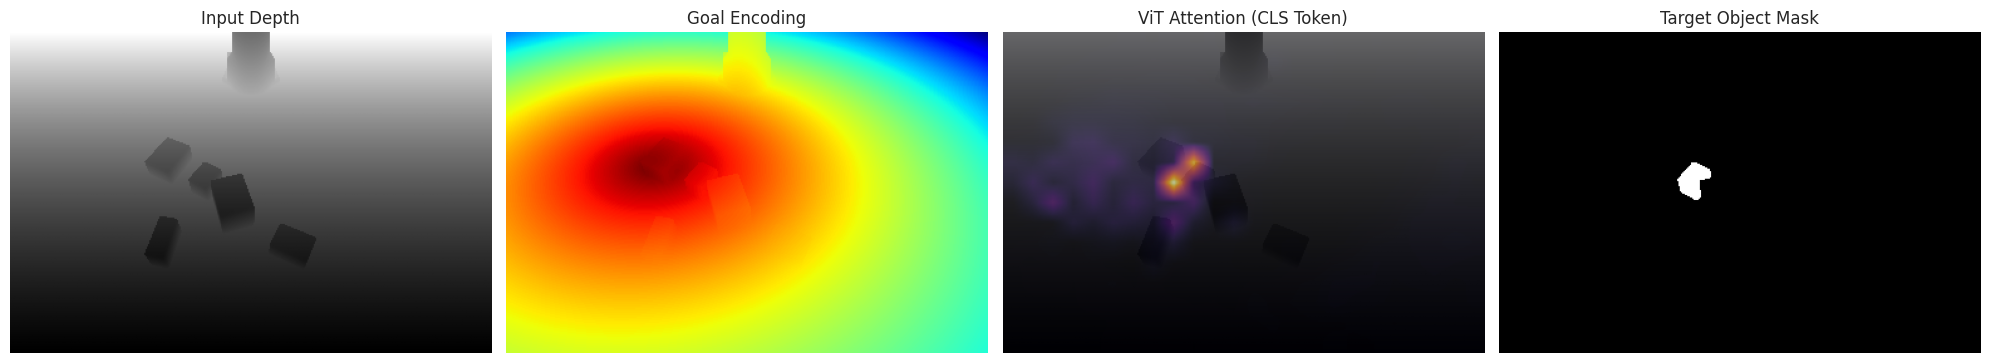

In [60]:
import cv2


def visualize_attention(idx_in_loader):
    # Get specific batch and sample
    batch = next(iter(loader))

    # Move to device
    depth = batch["depth"].to(device)
    mask = batch["mask"].to(device)
    dist_map = batch["dist_map"].to(device)

    # --- Get Attention ---
    # Shape: [Batch, Heads, NumPatches]
    attentions = get_last_layer_attention(distance_model, depth, mask, dist_map)

    # Pick the specific sample in the batch
    sample_idx = idx_in_loader % BATCH_SIZE

    # Average attention across all heads for the main visualization
    # Shape: [NumPatches] -> [384]
    avg_attn = attentions[sample_idx].mean(dim=0)

    # Reshape to grid (16x24)
    grid_h, grid_w = 16, 24
    attn_grid = avg_attn.reshape(grid_h, grid_w).detach().cpu().numpy()

    # Resize to image size (256x384)
    img_h, img_w = 256, 384
    attn_resized = cv2.resize(attn_grid, (img_w, img_h))

    # Normalize for visualization (0 to 1)
    attn_resized = (attn_resized - attn_resized.min()) / (attn_resized.max() - attn_resized.min())

    # --- Plotting ---
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))

    # 1. Original Depth (Visualized)
    d_img = batch["depth"][sample_idx].numpy()
    axs[0].imshow(d_img, cmap="gray")
    axs[0].set_title("Input Depth")
    axs[0].axis("off")

    # 2. The Goal (Distance Map)
    g_img = batch["dist_map"][sample_idx].numpy()
    # Invert distance map for viz (so goal is "hot")
    g_viz = 1.0 - g_img
    axs[1].imshow(g_viz, cmap="jet")
    axs[1].set_title("Goal Encoding")
    axs[1].axis("off")

    # 3. Attention Heatmap Overlay
    axs[2].imshow(d_img, cmap="gray")
    axs[2].imshow(attn_resized, cmap="inferno", alpha=0.6)  # Overlay
    axs[2].set_title("ViT Attention (CLS Token)")
    axs[2].axis("off")

    # 4. The Segmentation Mask (Target Object)
    m_img = batch["mask"][sample_idx].numpy()
    axs[3].imshow(m_img, cmap="gray")
    axs[3].set_title("Target Object Mask")
    axs[3].axis("off")

    plt.tight_layout()
    plt.show()

    # Optional: Check individual heads if the average is messy
    # Sometimes specific heads specialize (e.g., Head 1 looks at obstacles, Head 2 at goal)
    # plot_heads(attentions[sample_idx], img_h, img_w)


# Find an interesting index (e.g., a case where Distance Model worked but Offset failed)
# You can look at your `sample_metadata` dataframe to find good indices
interesting_indices = df[(df["distance_calls"] == 1) & (df["offset_calls"] > 2)].index.tolist()

if interesting_indices:
    print(f"Found {len(interesting_indices)} interesting samples. Showing the first one...")
    # Note: You need to find which batch this index belongs to.
    # For simplicity, here is how to visualize the first item of the first batch:
    for i, interesting_idx in enumerate(interesting_indices):
        visualize_attention(interesting_idx)
        if i > 10:
            break
else:
    print("No specific interesting samples found in evaluated subset, showing random.")
    visualize_attention(0)

In [48]:
import pandas as pd
import numpy as np

# Primitives mapping for clarity
primitives = ["push_x_pos", "push_x_neg", "push_y_pos", "push_y_neg", "lift_x", "lift_y", "pull_x", "pull_y"]
LIFT_INDICES = {4, 5}  # lift_x, lift_y
PULL_INDICES = {6, 7}  # pull_x, pull_y

# --- Step 1: Find the chosen primitive for each solved task ---


def get_chosen_primitive(row, ranking_col):
    """
    For a given row, iterate through its ranking and return the index
    of the first feasible primitive. Returns NaN if not solved.
    """
    # Check if the task was solved by this model
    calls_col = ranking_col.replace("_ranking", "_calls")
    if row[calls_col] > 8:  # Use your BUDGET constant if it's not 8
        return np.nan

    for prim_idx in row[ranking_col]:
        if row["feasibles"][prim_idx]:
            return prim_idx
    return np.nan  # Should not be reached if calls <= 8


# Apply this function for our main model
df["chosen_primitive_idx"] = df.apply(lambda row: get_chosen_primitive(row, "distance_ranking"), axis=1)

# --- Step 2: Isolate tasks where both lift and pull are viable options ---

# Create boolean flags for readability
df["is_lift_feasible"] = df["feasibles"].apply(lambda f: bool(f[4]) or bool(f[5]))
df["is_pull_feasible"] = df["feasibles"].apply(lambda f: bool(f[6]) or bool(f[7]))

# Filter for the "ambiguous" cases where the model has a real choice
ambiguous_df = df[df["is_lift_feasible"] & df["is_pull_feasible"]].copy()

print(f"Found {len(ambiguous_df)} tasks where both a lift and a pull were feasible.")

# --- Step 3: Analyze the model's choices in these ambiguous cases ---

# Get the value counts of the chosen primitives in this subset
choice_counts = ambiguous_df["chosen_primitive_idx"].value_counts().sort_index()

# Map indices to names and aggregate counts
lift_chosen_count = choice_counts.get(4, 0) + choice_counts.get(5, 0)
pull_chosen_count = choice_counts.get(6, 0) + choice_counts.get(7, 0)
other_chosen_count = len(ambiguous_df) - (lift_chosen_count + pull_chosen_count)


# --- Step 4: Print the results ---

total_choices = len(ambiguous_df)
print("\n--- Analysis of Choices when Lift and Pull are both Feasible ---")
print(f"Total ambiguous tasks: {total_choices}")
print("-" * 60)
print(f"Lift primitive chosen: {lift_chosen_count} times ({lift_chosen_count / total_choices:.2%})")
print(f"Pull primitive chosen: {pull_chosen_count} times ({pull_chosen_count / total_choices:.2%})")
print(f"Other primitive chosen: {other_chosen_count} times ({other_chosen_count / total_choices:.2%})")
print("-" * 60)

# Example of what might have been chosen as "other"
other_choices = ambiguous_df[~ambiguous_df["chosen_primitive_idx"].isin(LIFT_INDICES | PULL_INDICES)]
if not other_choices.empty:
    print("Primitives chosen instead of Lift/Pull:")
    print(other_choices["chosen_primitive_idx"].apply(lambda idx: primitives[int(idx)]).value_counts())

Found 3048 tasks where both a lift and a pull were feasible.

--- Analysis of Choices when Lift and Pull are both Feasible ---
Total ambiguous tasks: 3048
------------------------------------------------------------
Lift primitive chosen: 1650 times (54.13%)
Pull primitive chosen: 18 times (0.59%)
Other primitive chosen: 1380 times (45.28%)
------------------------------------------------------------
Primitives chosen instead of Lift/Pull:
chosen_primitive_idx
push_x_pos    371
push_x_neg    365
push_y_neg    330
push_y_pos    314
Name: count, dtype: int64


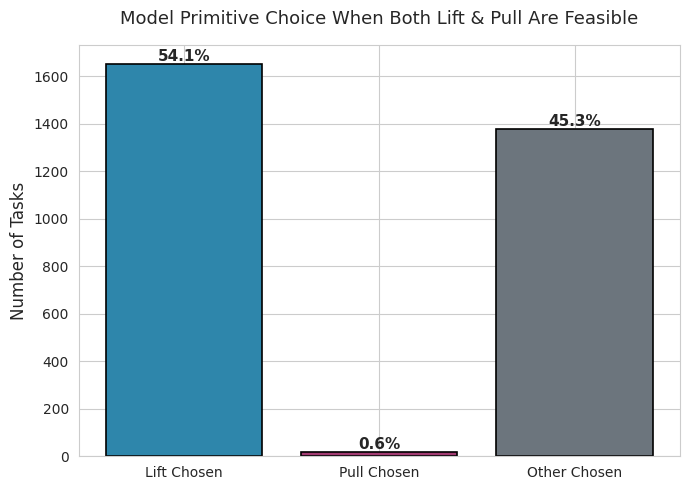

In [49]:
# --- Python code to generate the plot ---

# Make sure you have run the analysis code above first
labels = ["Lift Chosen", "Pull Chosen", "Other Chosen"]
counts = [lift_chosen_count, pull_chosen_count, other_chosen_count]
colors = ["#2E86AB", "#A23B72", "#6C757D"]

fig, ax = plt.subplots(figsize=(7, 5))
bars = ax.bar(labels, counts, color=colors, edgecolor="black", linewidth=1.2)

ax.set_ylabel("Number of Tasks", fontsize=12)
ax.set_title("Model Primitive Choice When Both Lift & Pull Are Feasible", fontsize=13, pad=15)

# Add percentage labels
total = sum(counts)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, height, f"{height / total:.1%}", ha="center", va="bottom", fontsize=11, fontweight="bold")

plt.tight_layout()
plt.savefig("lift_pull_preference.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [50]:
def visualize_sample(depth, mask, dist_map, threshold=0.1):
    img = np.stack([depth, depth, depth], axis=-1)
    img[mask > 0.5, 1] += 0.5  # Green: object
    img[:, :, 0] += ((1 - dist_map / threshold).clip(0, 1) ** 2) * 0.7
    img = img.clip(0, 1)

    plt.imshow(img)
    plt.axis("off")
    plt.tight_layout()


def visualize_dp(dp_key):
    with h5py.File(DATASET_PATH, "r") as f:
        dp = f[dp_key]
        visualize_sample(dp["depth"][()], dp["mask"][()], dp["dist_map"][()])

In [51]:
# Calculate mean absolute difference for each sample
df["mean_pred_diff"] = df.apply(lambda row: np.abs(row["distance_predictions"] - row["offset_predictions"]).mean(), axis=1)
df_sorted = df.sort_values("mean_pred_diff", ascending=False).reset_index(drop=True)
df_sorted = df_sorted[df_sorted['num_feasible'] != 0]

In [52]:
# Stack all absolute differences into array
abs_diffs = np.array([np.abs(row["distance_predictions"] - row["offset_predictions"]) for _, row in df.iterrows()])

# Calculate mean difference per primitive (across all samples)
mean_diff_per_primitive = abs_diffs.mean(axis=0)

# Find primitive with highest mean difference
max_primitive_idx = mean_diff_per_primitive.argmax()
max_diff = mean_diff_per_primitive[max_primitive_idx]

print(f"Primitive with highest average difference: {max_primitive_idx}")
print(f"Average difference: {max_diff:.4f}")

# Optionally, show top 10 primitives
top_k = 10
top_primitive_indices = mean_diff_per_primitive.argsort()[::-1][:top_k]
print(f"\nTop {top_k} primitives by average difference:")
for i, prim_idx in enumerate(top_primitive_indices, 1):
    print(f"{i}. Primitive {prim_idx}: {mean_diff_per_primitive[prim_idx]:.4f}")

Primitive with highest average difference: 6
Average difference: 0.1433

Top 10 primitives by average difference:
1. Primitive 6: 0.1433
2. Primitive 7: 0.1415
3. Primitive 5: 0.1397
4. Primitive 4: 0.1376
5. Primitive 1: 0.0629
6. Primitive 3: 0.0621
7. Primitive 0: 0.0596
8. Primitive 2: 0.0555


idx                                                                  3810
global_idx                                                          48509
key                                                         dp_9737_obj_0
feasibles                        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
num_feasible                                                          1.0
distance_calls                                                          3
offset_calls                                                            1
cnn_calls                                                               1
random_calls                                                            3
hardcoded_calls                                                         7
distance_ranking                                 [5, 7, 2, 4, 6, 1, 0, 3]
distance_predictions    [0.008568642, 0.01371005, 0.6370189, 0.0009995...
offset_ranking                                   [2, 4, 6, 7, 5, 0, 1, 3]
offset_predictions      [0.033549547, 

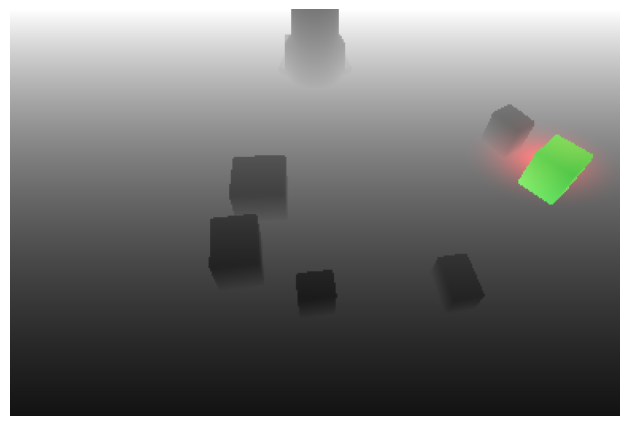

In [53]:
for k, v in df_sorted.iterrows():
    print(v)
    visualize_dp(v["key"])
    break

In [54]:
best_examples = df[(df["distance_calls"] == 1) & (df["cnn_calls"] >= 2)].sort_values("cnn_calls", ascending=False).head(10)

print("Best examples - we solve immediately, others struggle:")
for _, row in best_examples.iterrows():
    print(f"Key: {row['key']}")
    print(f"  Feasible primitives: {row['num_feasible']}/{len(primitives)}")
    print(f"  Distance: 1 call | Offset: {row["offset_calls"]} Random: {row['random_calls']} | Hardcoded: {row['hardcoded_calls']} | CNN: {row['cnn_calls']}")
    print()

Best examples - we solve immediately, others struggle:
Key: dp_9670_obj_3
  Feasible primitives: 1.0/8
  Distance: 1 call | Offset: 3 Random: 4 | Hardcoded: 1 | CNN: 5

Key: dp_9723_obj_0
  Feasible primitives: 1.0/8
  Distance: 1 call | Offset: 2 Random: 6 | Hardcoded: 1 | CNN: 5

Key: dp_9902_obj_0
  Feasible primitives: 2.0/8
  Distance: 1 call | Offset: 2 Random: 2 | Hardcoded: 2 | CNN: 4

Key: dp_9815_obj_1
  Feasible primitives: 1.0/8
  Distance: 1 call | Offset: 2 Random: 1 | Hardcoded: 1 | CNN: 4

Key: dp_9878_obj_6
  Feasible primitives: 1.0/8
  Distance: 1 call | Offset: 2 Random: 2 | Hardcoded: 1 | CNN: 4

Key: dp_9915_obj_0
  Feasible primitives: 1.0/8
  Distance: 1 call | Offset: 4 Random: 6 | Hardcoded: 1 | CNN: 4

Key: dp_9975_obj_1
  Feasible primitives: 2.0/8
  Distance: 1 call | Offset: 2 Random: 4 | Hardcoded: 2 | CNN: 4

Key: dp_8972_obj_0
  Feasible primitives: 1.0/8
  Distance: 1 call | Offset: 1 Random: 3 | Hardcoded: 2 | CNN: 4

Key: dp_8968_obj_3
  Feasible pri

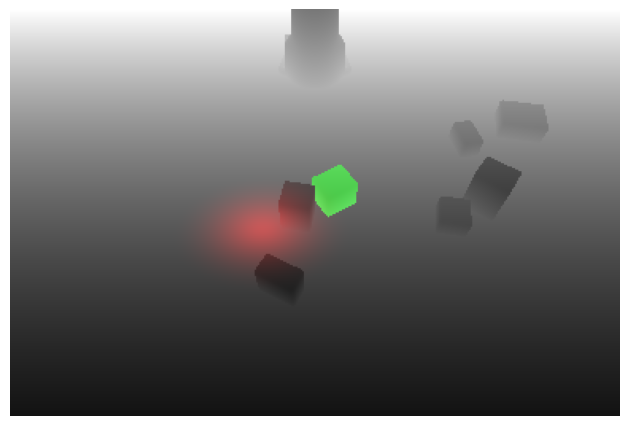

In [55]:
with h5py.File("combined-dataset.h5", "r") as f:
    dp = f["dp_9670_obj_3"]
    visualize_sample(dp["depth"][()], dp["mask"][()], dp["dist_map"][()])
    plt.show()

In [56]:
import torch

print("\n" + "=" * 60)
print("CLASSIFICATION METRICS & TYPE ANALYSIS")
print("=" * 60)


def compute_metrics(probs, targets, threshold=0.5):
    preds = (probs > threshold).float()

    # Per-column (per-primitive) metrics
    acc = (preds == targets).float().mean(dim=0)

    tp = (preds * targets).sum(dim=0)
    fp = (preds * (1 - targets)).sum(dim=0)
    fn = ((1 - preds) * targets).sum(dim=0)

    # Add epsilon to avoid division by zero
    prec = tp / (tp + fp + 1e-8)
    rec = tp / (tp + fn + 1e-8)
    f1 = 2 * prec * rec / (prec + rec + 1e-8)

    return acc, prec, rec, f1


models_to_eval = {
    "distance_model": distance_model,
    "offset_model": offset_model,
    "cnn_model": cnn_model,
}

# 1. Define Groups based on primitive names
# We assume 'primitives' list exists (e.g. ['push_x_pos', 'lift_x', ...])
primitive_groups = {"Pushes": [], "Lifts": [], "Pulls": []}

# Dynamically find indices for each group
for i, name in enumerate(primitives):
    if "push" in name:
        primitive_groups["Pushes"].append(i)
    elif "lift" in name:
        primitive_groups["Lifts"].append(i)
    elif "pull" in name:
        primitive_groups["Pulls"].append(i)

# 2. Main Evaluation Loop
for model_name, model in models_to_eval.items():
    all_probs = []
    all_targets = []

    # Ensure model is in eval mode
    model.eval()

    with torch.no_grad():
        for batch in loader:
            depth = batch["depth"].to(device)
            mask = batch["mask"].to(device)
            dist_map = batch["dist_map"].to(device)
            target_offset = batch["target_offset"].to(device)
            quat = batch["quat"].to(device)
            feasibles = batch["feasibles"]

            if model_name == "offset_model":
                scores = model(depth, mask, target_offset, quat)
            else:
                scores = model(depth, mask, dist_map, quat)

            probs = torch.sigmoid(scores).cpu()
            all_probs.append(probs)
            all_targets.append(feasibles)

    all_probs = torch.cat(all_probs)
    all_targets = torch.cat(all_targets)

    # Compute raw per-primitive metrics
    acc, prec, rec, f1 = compute_metrics(all_probs, all_targets)

    print(f"\n{model_name.upper()}")
    print("-" * 30)
    print(f"  Overall (Macro) - Acc: {acc.mean():.3f} | Prec: {prec.mean():.3f} | Rec: {rec.mean():.3f} | F1: {f1.mean():.3f}")

    print(f"\n  Per-Primitive Detail:")
    for i, prim in enumerate(primitives):
        print(f"    {prim:15} | Acc: {acc[i]:.3f} | Prec: {prec[i]:.3f} | Rec: {rec[i]:.3f} | F1: {f1[i]:.3f}")

    # 3. New Grouped Analysis Output
    print(f"\n  Aggregated by Primitive Type:")
    print(f"    {'Type':10} | {'Acc':<5} | {'Prec':<5} | {'Rec':<5} | {'F1':<5}")
    print(f"    {'-' * 43}")

    for group_name, indices in primitive_groups.items():
        if not indices:
            continue  # Skip empty groups

        # Calculate mean of metrics for the indices in this group
        g_acc = acc[indices].mean().item()
        g_prec = prec[indices].mean().item()
        g_rec = rec[indices].mean().item()
        g_f1 = f1[indices].mean().item()

        print(f"    {group_name:10} | {g_acc:.3f} | {g_prec:.3f} | {g_rec:.3f} | {g_f1:.3f}")


CLASSIFICATION METRICS & TYPE ANALYSIS



DISTANCE_MODEL
------------------------------
  Overall (Macro) - Acc: 0.917 | Prec: 0.842 | Rec: 0.913 | F1: 0.875

  Per-Primitive Detail:
    push_x_pos      | Acc: 0.964 | Prec: 0.839 | Rec: 0.982 | F1: 0.905
    push_x_neg      | Acc: 0.962 | Prec: 0.837 | Rec: 0.980 | F1: 0.903
    push_y_pos      | Acc: 0.967 | Prec: 0.842 | Rec: 0.978 | F1: 0.905
    push_y_neg      | Acc: 0.962 | Prec: 0.835 | Rec: 0.980 | F1: 0.902
    lift_x          | Acc: 0.873 | Prec: 0.870 | Rec: 0.845 | F1: 0.857
    lift_y          | Acc: 0.873 | Prec: 0.873 | Rec: 0.850 | F1: 0.861
    pull_x          | Acc: 0.864 | Prec: 0.811 | Rec: 0.842 | F1: 0.826
    pull_y          | Acc: 0.868 | Prec: 0.829 | Rec: 0.846 | F1: 0.837

  Aggregated by Primitive Type:
    Type       | Acc   | Prec  | Rec   | F1   
    -------------------------------------------
    Pushes     | 0.964 | 0.838 | 0.980 | 0.904
    Lifts      | 0.873 | 0.871 | 0.848 | 0.859
    Pulls      | 0.866 | 0.820 | 0.844 | 0.832

OFFSET_MODEL

In [57]:
push_primitives = ["push_x_pos", "push_x_neg", "push_y_pos", "push_y_neg"]
push_indices = [primitives.index(p) for p in push_primitives]

interesting_cases = []

for idx, row in df.iterrows():
    offset_ranking = row["offset_ranking"]
    cnn_ranking = row["cnn_ranking"]
    distance_ranking = row["distance_ranking"]
    distance_preds = row["distance_predictions"]
    cnn_preds = row["cnn_predictions"]
    offset_preds = row["offset_predictions"]
    feasibles = row["feasibles"]
    num_feasible = row["num_feasible"]

    for prim_name, prim_idx in zip(push_primitives, push_indices):
        if feasibles[prim_idx]:
            continue

        offset_rank = np.where(offset_ranking == prim_idx)[0][0] + 1
        distance_rank = np.where(distance_ranking == prim_idx)[0][0] + 1
        cnn_rank = np.where(cnn_ranking == prim_idx)[0][0] + 1

        if offset_rank <= 3 and distance_rank > offset_rank and distance_rank > cnn_rank and num_feasible > 1:
            interesting_cases.append(
                {
                    "idx": idx,
                    "key": row["key"],
                    "primitive": prim_name,
                    "offset_rank": offset_rank,
                    "distance_rank": distance_rank,
                    "cnn_rank": cnn_rank,
                    "rank_diff": distance_rank - offset_rank,
                    "distance_prediction": distance_preds[prim_idx],
                    "offset_prediction": offset_preds[prim_idx],
                    "cnn_prediction": cnn_preds[prim_idx],
                    "pred_diff": distance_preds[prim_idx] - offset_preds[prim_idx],
                    "num_feasible": row["num_feasible"],
                }
            )

interesting_cases.sort(key=lambda x: x["pred_diff"], reverse=False)

print(f"Found {len(interesting_cases)} interesting failure cases")
print("\nTop 10 cases where Offset Model failed most badly:")
print("=" * 80)
for i, case in enumerate(interesting_cases[:10]):
    print(f"\n{i + 1}. Sample idx: {case['idx']}")
    print(f"   Key: {case['key']}")
    print(f"   Primitive: {case['primitive']}")
    print(f"   Offset Model ranked it: #{case['offset_rank']} (WRONG - infeasible)")
    print(f"   Distance Model ranked it: #{case['distance_rank']} (BETTER)")
    print(f"   Rank difference: {case['rank_diff']}")
    print(f"   Distance model prediction: {case['distance_prediction']:.3f}")
    print(f"   # Feasible primitives: {case['num_feasible']}")

Found 503 interesting failure cases

Top 10 cases where Offset Model failed most badly:

1. Sample idx: 1370
   Key: dp_9195_obj_4
   Primitive: push_x_neg
   Offset Model ranked it: #2 (WRONG - infeasible)
   Distance Model ranked it: #6 (BETTER)
   Rank difference: 4
   Distance model prediction: 0.011
   # Feasible primitives: 2.0

2. Sample idx: 3818
   Key: dp_9738_obj_2
   Primitive: push_x_neg
   Offset Model ranked it: #3 (WRONG - infeasible)
   Distance Model ranked it: #5 (BETTER)
   Rank difference: 2
   Distance model prediction: 0.046
   # Feasible primitives: 2.0

3. Sample idx: 2462
   Key: dp_9434_obj_2
   Primitive: push_x_neg
   Offset Model ranked it: #3 (WRONG - infeasible)
   Distance Model ranked it: #5 (BETTER)
   Rank difference: 2
   Distance model prediction: 0.071
   # Feasible primitives: 4.0

4. Sample idx: 2517
   Key: dp_9446_obj_0
   Primitive: push_x_neg
   Offset Model ranked it: #1 (WRONG - infeasible)
   Distance Model ranked it: #3 (BETTER)
   Rank 

2 2 6 0.77950925 0.74207675 0.010921076


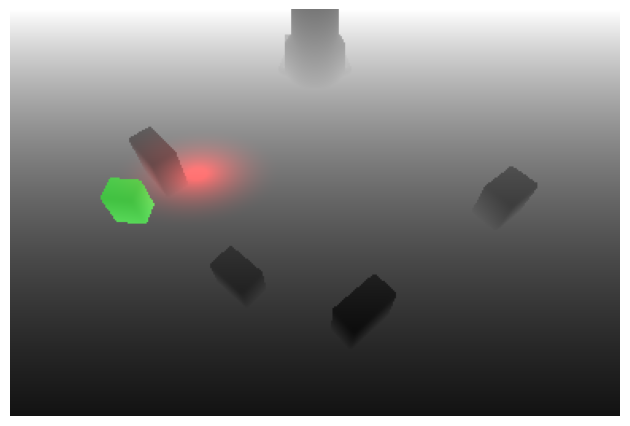

3 3 5 0.7813847 0.74642247 0.046306785


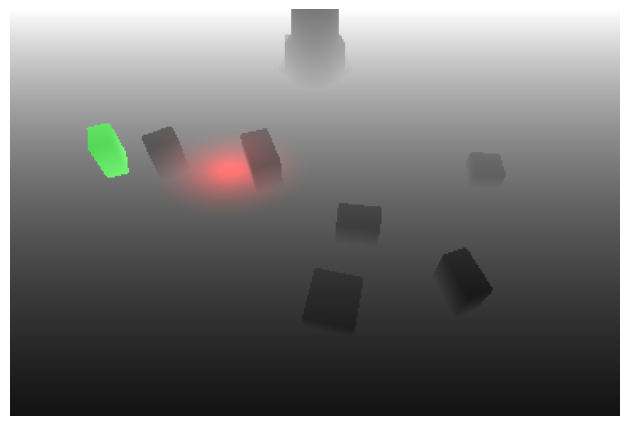

3 1 5 0.77293193 0.716964 0.07064392


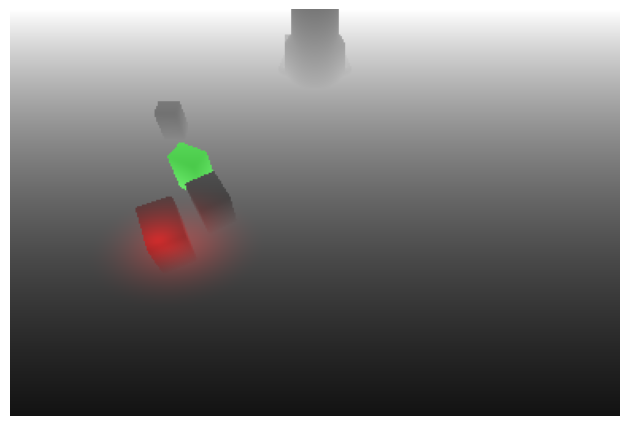

1 1 3 0.8014234 0.7093725 0.10930055


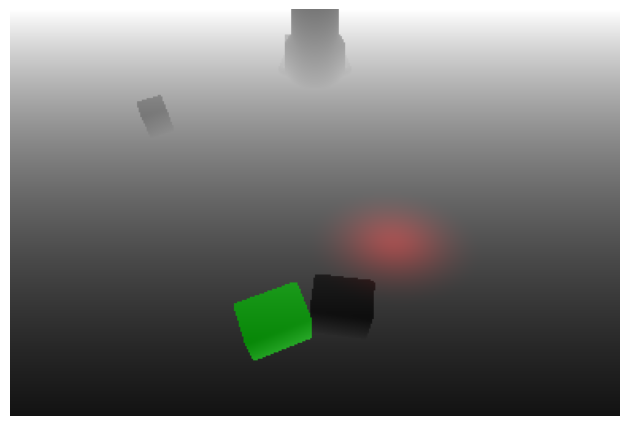

1 1 3 0.7908723 0.68246174 0.09990142


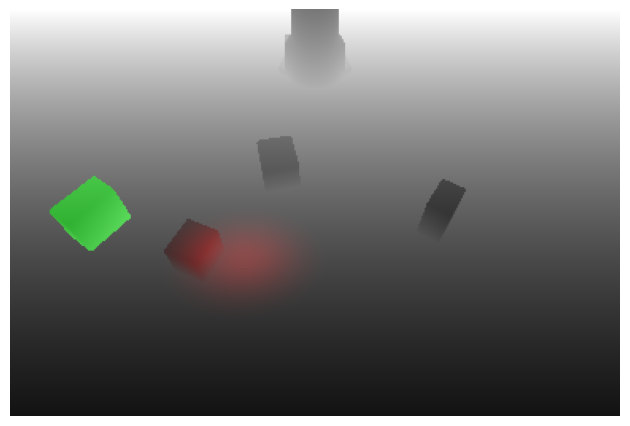

2 1 6 0.74013466 0.72234744 0.05050723


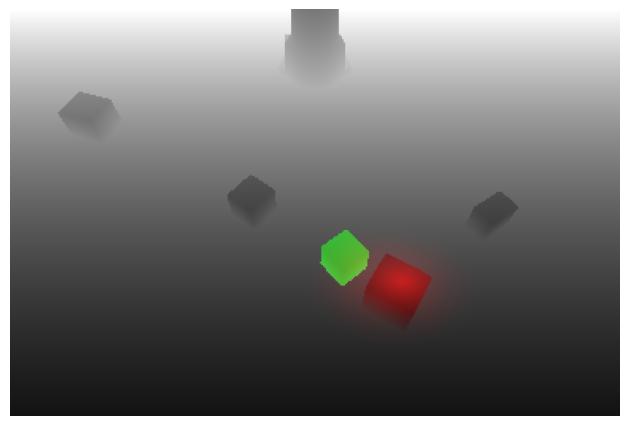

1 1 3 0.79663825 0.7114101 0.11162841


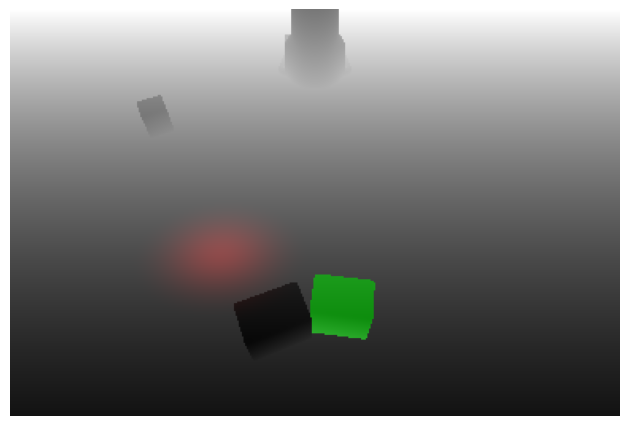

2 1 6 0.74918115 0.6461842 0.07133983


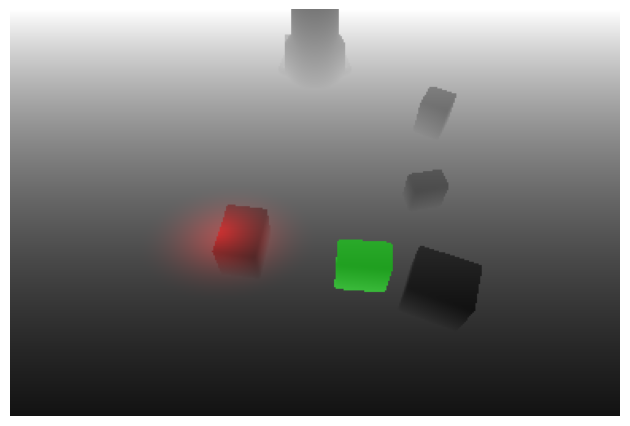

1 1 5 0.7564803 0.73549354 0.08140666


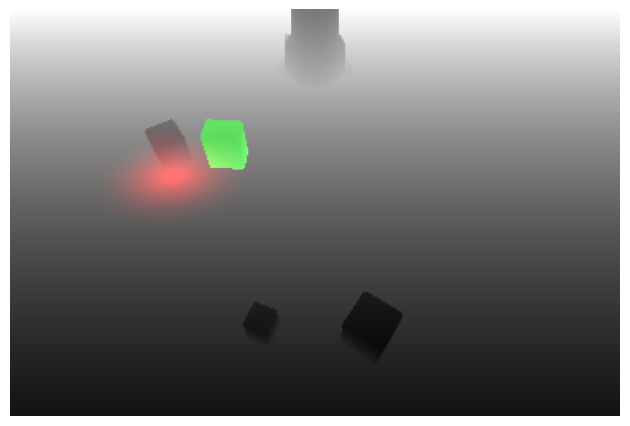

1 1 7 0.6960896 0.6409572 0.022098672


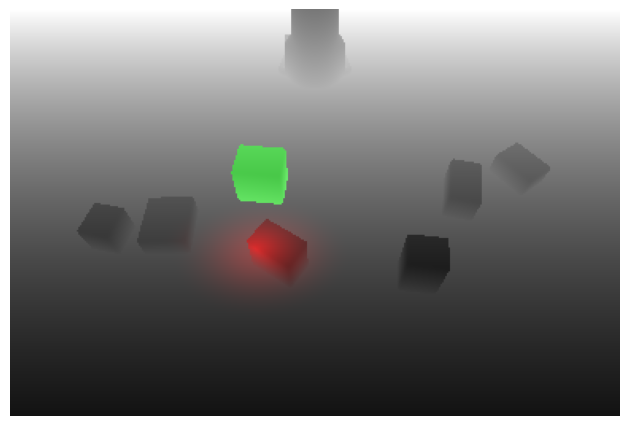

In [58]:
for i in range(10):
    case = interesting_cases[i]
    print(case["offset_rank"], case["cnn_rank"], case["distance_rank"], case["offset_prediction"], case["cnn_prediction"], case["distance_prediction"])
    fig = visualize_dp(case["key"])
    plt.savefig(f"failure_case_{i}.pdf")
    plt.show()